# Sentiment Analysis

## A binary classification of IMDB reviews' sentiments (positive or negative).

In [1]:
import matplotlib.pyplot as plt
import os
import re 
import shutil
import string 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1', url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [3]:
os.listdir(dataset_dir) 

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
train_dir

'.\\aclImdb\\train'

In [5]:
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


To load the data off disk and prepare it into a format suitable for training, we use the "text_dataset_from_directory"
utility, which expects a directory structure as follows:

```main_directory/```
```...class_a/```
```......a_text_1.txt```
```......a_text_2.txt```
```...class_b/```
```......b_text_1.txt```
```......b_text_2.txt```

So we need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews,
```aclImdb/train/pos``` and ```aclImdb/train/neg```, respectively.

In [7]:
# Removing the additional folders from the dataset.
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
# Creating a validation set using an 80:20 split of the training data by using the "validation_split" argument.
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
# Iterating over the dataset and printing out a few examples.
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
raw_train_ds.class_names[0]

'neg'

In [11]:
raw_train_ds.class_names[1]

'pos'

In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [14]:
# Writing a custom standardization function to remove the HTML tags.
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', 
                                             ' ')
    return tf.strings.regex_replace(stripped_html, 
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [15]:
max_features = 10000
sequence_length = 250

# Creating a "TextVectorization" layer to standardize, tokenize, and vectorize the data.
# Setting the "output_mode" to "int" to create unique integer indices for each token.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [16]:
# Calling the "adapt" function to fit the state of the preprocessing layer to the dataset,
# causing the model to build an index of strings to integers.

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
# Creating a function to see the result of using this layer to preprocess some data.
def vectorize_text(text, label): 
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label 

In [18]:
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review: ", first_review)
print("Label: ", raw_train_ds.class_names[first_label])
print("Vectorized review: ", vectorize_text(first_review, first_label))

Review:  tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label:  neg
Vectorized review:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
 

Each token has been replaced by an integer.

In [19]:
# Looking up some tokens (strings) using sample integers that correspond to them, by calling the ".get_vocabulary()" function on the layer.
print("86 => ", vectorize_layer.get_vocabulary()[86])
print("282 => ", vectorize_layer.get_vocabulary()[282])
print("1287 => ", vectorize_layer.get_vocabulary()[1287])
print("313 => ", vectorize_layer.get_vocabulary()[313])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

86 =>  great
282 =>  someone
1287 =>  silent
313 =>  night
Vocabulary size: 10000


In [20]:
# Final preprocessing step:
# Applying the "TextVectorization" layer we created earlier to the train, validation, and test datasets.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configuring the dataset for Performance

In [21]:
# Using the "prefetch()" methods to overlap data preprocessing and model execution while training.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model

In [22]:
embedding_dim = 16

model = tf.keras.Sequential([
    # Embedding layer: takes the integer-encoded reviews and looks up an embedding vector for each work-index.
    # These vectors are learned as the model trains. The vectors add a dimension to the output array.
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    # GlobalAveragePooling1D layer: returns a fixed-length output vector for each example by averaging over the sequence dimension.
    # This allows the model to handle input of variable length, in the simplest way possible.
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    # Dense layer: is densely connected with a single output node.
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

### Loss function and optimizer

In [23]:
# Choosing the "BinaryCrossentropy" as the loss function for this binary classification problem.
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Training the model

In [24]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 22s 35ms/step - loss: 0.6632 - binary_accuracy: 0.6967 - val_loss: 0.6134 - val_binary_accuracy: 0.7720
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5472 - binary_accuracy: 0.8004 - val_loss: 0.4968 - val_binary_accuracy: 0.8234
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4430 - binary_accuracy: 0.8451 - val_loss: 0.4190 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3770 - binary_accuracy: 0.8650 - val_loss: 0.3728 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3343 - binary_accuracy: 0.8787 - val_loss: 0.3443 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3040 - binary_accuracy: 0.8903 - val_loss: 0.3255 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 2s 4ms/s

### Evaluating the model

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss = ", loss)
print("Accuracy = ", accuracy)

782/782 [==============================] - 14s 18ms/step - loss: 0.3100 - binary_accuracy: 0.8737
Loss =  0.309998482465744
Accuracy =  0.8737199902534485


In [27]:
history.history

{'loss': [0.6631720066070557,
  0.5471991300582886,
  0.44300416111946106,
  0.3769572377204895,
  0.3342525064945221,
  0.3040425479412079,
  0.28099316358566284,
  0.2622872292995453,
  0.2457743138074875,
  0.23100411891937256],
 'binary_accuracy': [0.6966999769210815,
  0.8004000186920166,
  0.8451499938964844,
  0.8650000095367432,
  0.8787000179290771,
  0.8903499841690063,
  0.897350013256073,
  0.9049999713897705,
  0.911300003528595,
  0.9162499904632568],
 'val_loss': [0.6134254932403564,
  0.4968482553958893,
  0.41900137066841125,
  0.3728153705596924,
  0.34426605701446533,
  0.32551485300064087,
  0.312190979719162,
  0.3028401732444763,
  0.29623550176620483,
  0.2915304899215698],
 'val_binary_accuracy': [0.7720000147819519,
  0.8234000205993652,
  0.8478000164031982,
  0.8610000014305115,
  0.8677999973297119,
  0.871399998664856,
  0.8733999729156494,
  0.8766000270843506,
  0.8772000074386597,
  0.8777999877929688]}

In [28]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

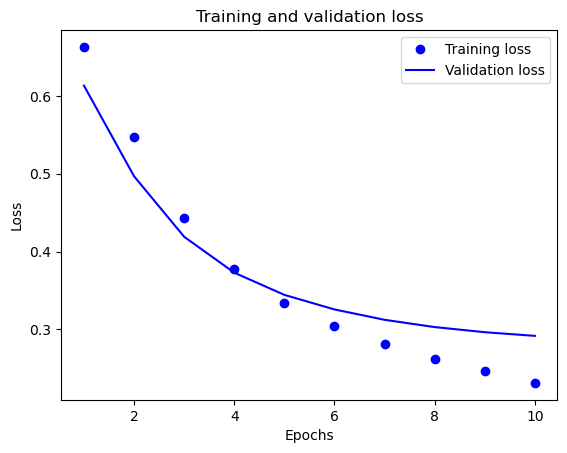

In [29]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

x_axis = range(1, len(acc) + 1) # Number of epochs for x_axis.

plt.plot(x_axis, loss, 'bo', label='Training loss')
plt.plot(x_axis, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

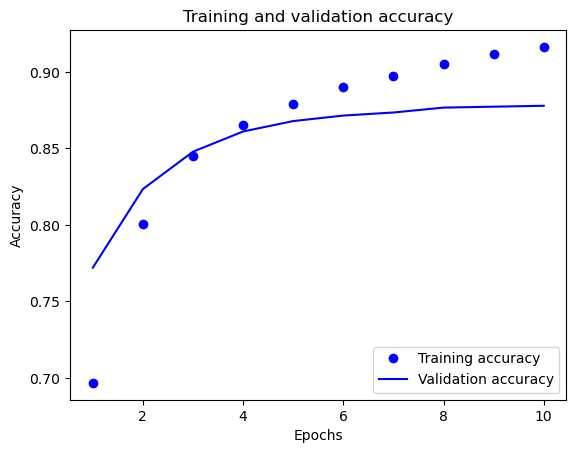

In [30]:
plt.plot(x_axis, acc, 'bo', label='Training accuracy')
plt.plot(x_axis, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Exporting the model

In [31]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

# Testing the model with "raw_test_ds", which yields raw strings.
loss, accuracy = export_model.evaluate(raw_test_ds)
accuracy

782/782 [==============================] - 17s 22ms/step - loss: 0.3100 - accuracy: 0.8737


0.8737199902534485